In [52]:
from utils import get_conn
from pyathena.util import as_pandas
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import functools as ft
from typing import List, Set
import pandas as pd
from sodapy import Socrata
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from visdata import summary_table, note_lengths, icd_summary
from utils import tree_to_nx
from icd9.icd9 import ICD9
from colour import Color
import networkx as nx
import matplotlib.pyplot as plt
from constants import PROJ_DIR
import os

## Read in Data

In [2]:
with get_conn() as CONN:
    cursor = CONN.cursor()
    # read in a random sample of notes
    icd_codes = as_pandas(cursor.execute("select icd9_code from mimiciii.diagnoses_icd"))

## Network Vis

In [8]:
tree = ICD9("icd9/codes.json")
G = tree_to_nx(tree.children[0].children[0])

In [40]:
blue = Color("blue")
red = Color("red")
degrees = dict(G.degree)
grad = list(blue.range_to(red, (max(degrees.values())) + 1))
icd_colors = {icd: grad[d] for icd, d in degrees.items()}

In [41]:
icd_df = pd.DataFrame(data={"icd": list(icd_colors.keys()), "colors": list(icd_colors.values())})
icd_df = icd_df.set_index("icd")
icd_df = icd_df.reindex(G.nodes())

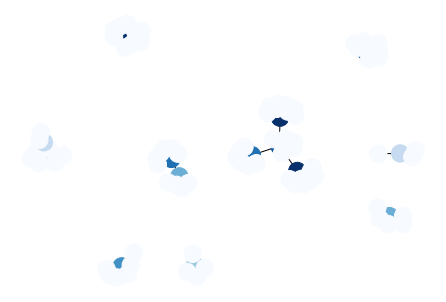

In [47]:
nx.draw(G, with_labels=False, node_color=list(degrees.values()), cmap=plt.cm.Blues)

## Summative Visualizations

### Summary Table

In [17]:
summary_table = pd.read_csv("data/full_summary.csv")

In [28]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [33]:
latex = summary_table.to_latex()
print(latex)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    Totals &      Male &  Medicare &    Female &   Private &  Medicaid &  Government &  Self Pay \\
Category                 &           &           &           &           &           &           &             &           \\
\midrule
Patients                 &  46520.00 &  26121.00 &  21002.00 &  20399.00 &  19663.00 &   4570.00 &     1614.00 &    600.00 \\
Admissions               &  58976.00 &  32950.00 &  28215.00 &  26026.00 &  22582.00 &   5785.00 &     1783.00 &    611.00 \\
ICD9 Codes               &  11501.00 &   5852.00 &   5023.00 &   5649.00 &   5718.00 &   3989.00 &     2657.00 &   1467.00 \\
Deaths                   &   5836.00 &   3141.00 &   3903.00 &   2695.00 &   1372.00 &    381.00 &       90.00 &     95.00 \\
Admissions Per Patient   &      1.27 &      1.26 &      1.34 &      1.28 &      1.15 &      1.27 &        1.10 &      1.02 \\
ICD9 Codes Per Patient   &      0.25 &      0.22 &      0.24 &      0.28 &      0.29 &      0.8

## ICD Code Summary

In [48]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [49]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [50]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED TO PERSONAL AND FAMILY HISTORY,18358,228


In [51]:
print(icd_latex)

\begin{tabular}{lllrr}
\toprule
{} &     Code &                                                                                                          Description &  Mimic-iii Counts &  Nodes in ICD Tree \\
\midrule
2  &  390-459 &  DISEASES OF THE CIRCULATORY SYSTEM  &  124782 &  516 \\
3  &  240-279 &  ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS  &  52095 &  333 \\
0  &  460-519 &  DISEASES OF THE RESPIRATORY SYSTEM  &  40989 &  277 \\
11 &  800-999 &  INJURY AND POISONING  &  35518 &  1881 \\
5  &  520-579 &  DISEASES OF THE DIGESTIVE SYSTEM  &  34595 &  625 \\
1  &  580-629 &  DISEASES OF THE GENITOURINARY SYSTEM  &  32860 &  471 \\
8  &  780-799 &  SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS  &  28873 &  372 \\
6  &  320-389 &  DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS  &  20397 &  1633 \\
15 &  001-139 &  INFECTIOUS AND PARASITIC DISEASES  &  19507 &  1057 \\
13 &  V10-V19 &  PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED TO PERSONAL AND FAMILY HI

### Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

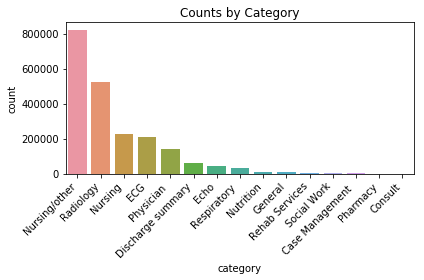

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

### Distribution on Word Counts in Notes

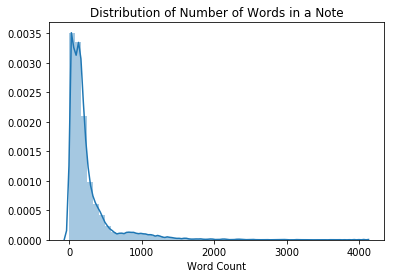

In [122]:
ax = sns.distplot(samp_df["processed"].apply(lambda x: len(x)))
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.show()

## Join with DRG Codes

In [48]:
drg_query: str = f"select * from mimiciii.drgcodes"
drg_df = as_pandas(cursor.execute(drg_query))
drg_df["hadm_id"] = drg_df["hadm_id"].apply(lambda x: float(x))
sub_drg_df = drg_df.loc[:,["hadm_id", "drg_type", "drg_code", "description"]]
sub_drg_df.columns = ["hadm_id", "drg_type", "drg_code", "drg_description"]
samp_drg_df = samp_df.merge(sub_drg_df, on="hadm_id", how="left")

## Get document embeddings

In [82]:
# generate gensim tokens
def read_corpus(docs: List[str]):
    for i, doc in enumerate(docs):
        tokens = gensim.utils.simple_preprocess(doc)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        
train_corpus = list(read_corpus(samp_drg_df["text"].tolist()))

In [65]:
# train doc2vec model
doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
doc2vec.build_vocab(train_corpus)
doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

In [91]:
# generate embeddings
samp_drg_df["embeddings"] = samp_drg_df["processed"].apply(doc2vec.infer_vector)

## Forecast DRG Codes with Logistic Regression

In [113]:
# train logistic regression
labels = LabelEncoder().fit_transform(samp_drg_df["drg_code"].tolist())
X_train, X_test, y_train, y_test = train_test_split(samp_drg_df["embeddings"].tolist(), \
                                                    labels, \
                                                    test_size=0.2)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


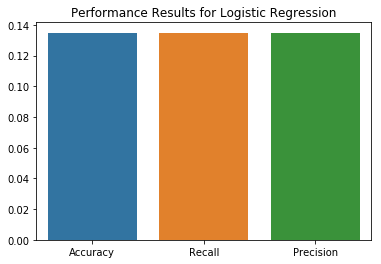

In [121]:
# measure performance
y_preds = clf.predict(X_test)
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds, average='micro')
prec = precision_score(y_test, y_preds, average='micro')
x = ["Accuracy", "Recall", "Precision"]
y = [acc, rec, prec]
ax = sns.barplot(x=x, y=y)
ax.set_title("Performance Results for Logistic Regression")
plt.show()

## Luigi Pipelining
`Collection -> Preprocessing -> Training -> Evaluation`

## Future Work

- Determine between pursuing redundancy, patient outcomes, or billing
- Build Luigi pipeline
- Better document embedding
- Better model selection

## Expore Medicare Data

In [21]:
client = Socrata("data.cms.gov", None)

In [22]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("fs4p-t5eq", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)